# Compare Constants

This Notebook accesses values from the xml record library and generates bokeh plots for the data.

#### Library imports

In [1]:
#Standard Python libraries
from __future__ import print_function
import os

#http://www.numpy.org/
import numpy as np

#http://pandas.pydata.org/
import pandas as pd

#https://github.com/usnistgov/iprPy
import iprPy

#https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

In [17]:
#http://bokeh.pydata.org/
from bokeh.plotting import figure, output_file, show
from bokeh.embed import components
from bokeh.resources import Resources
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

## Input parameters

### Pick database to access

- __dbasename__ is used here to predefine different dbase settings
- __dbase__ is the iprPy.Database object to use for accessing a database#### XML record library path

In [3]:
dbasename = 'local'

# 'local' is a local directory
if   dbasename == 'local':
    dbase = iprPy.Database('local',   host='C:\Users\lmh1\Documents\calculations\ipr\library')

# 'curator' is a local MDCS curator
elif dbasename == 'curator':
    dbase = iprPy.Database('curator', host='http://127.0.0.1:8000/', 
                                      user='admin', 
                                      pswd='admin')

# 'iprhub' is the remote MDCS curator at iprhub
elif dbasename == 'iprhub':
    dbase = iprPy.Database('curator', host='https://iprhub.nist.gov/', 
                                      user='lmh1',
                                      pswd='C:/users/lmh1/documents/iprhub/iprhub_password.txt',
                                      cert='C:/users/lmh1/documents/iprhub/iprhub-ca.pem')
else:
    raise ValueError('unknown dbasename ' + dbasename)

### Specify record styles

- __prototype_recordstyle__ specifies the record style for the crystal prototype models.

- __scan_recordstyle__ specifies the record style for the calc_E_vs_r_scan

- __static_recordstyle__ specifies the record style for the calc_system_relax and calc_LAMMPS_ELASTIC

- __dynamic_recordstyle__ specifies the record style for the calc_dynamic_relax

In [4]:
prototype_recordstyle = 'crystal-prototype'
scan_recordstyle =      'calculation-cohesive-energy-relation'
static_recordstyle =    'calculation-system-relax'
dynamic_recordstyle =   'calculation-dynamic-relax'

## Read records into pandas DataFrames

- __prototype_df__ has all prototype records

In [5]:
prototype_df = []
for record in dbase.iget_records(style=prototype_recordstyle):
    prototype_df.append(record.todict())
prototype_df = pd.DataFrame(prototype_df)
print(str(len(prototype_df)) + ' records loaded')
print(prototype_df.keys())

19 records loaded
Index([u'Pearson_symbol', u'Strukturbericht', u'a', u'b', u'c',
       u'crystal_family', u'id', u'key', u'name', u'natypes', u'prototype',
       u'sg_HG', u'sg_Schoen', u'sg_number'],
      dtype='object')


- __scan_df__ has all E_vs_r_scan records

In [7]:
scan_df = []
for record in dbase.iget_records(style=scan_recordstyle):
    scan_df.append(record.todict())
scan_df = pd.DataFrame(scan_df)
print(str(len(scan_df)) + ' records loaded')
print(scan_df.keys())

5942 records loaded
Index([u'calc_key', u'calc_script', u'e_vs_r_plot', u'error', u'load',
       u'maximum_r', u'minimum_r', u'number_min_states', u'number_of_steps_r',
       u'potential_id', u'potential_key', u'prototype', u'sizemults',
       u'status', u'symbols'],
      dtype='object')


- __static_df__ has all relax_structure and LAMMPS_ELASTIC records

In [6]:
static_df = []
for record in dbase.iget_records(style=static_recordstyle):
    try:
        static_df.append(record.todict())
    except:
        print('Failed to load', record.name)
static_df = pd.DataFrame(static_df)
print(str(len(static_df)) + ' records loaded')
print(static_df.keys())

76830 records loaded
Index([u'C', u'E_cohesive', u'calc_key', u'calc_script', u'error', u'final_a',
       u'final_b', u'final_c', u'initial_a', u'initial_b', u'initial_c',
       u'load', u'load_options', u'potential_id', u'potential_key',
       u'pressure_xx', u'pressure_yy', u'pressure_zz', u'prototype',
       u'sizemults', u'status', u'strainrange', u'symbols', u'temperature'],
      dtype='object')


- __dynamic_df__ has all relax_dynamic 

In [7]:
dynamic_df = []
for record in dbase.iget_records(style=dynamic_recordstyle):
    dynamic_df.append(record.todict())
dynamic_df = pd.DataFrame(dynamic_df)
print(str(len(dynamic_df)) + ' records loaded')
print(dynamic_df.keys())

7677 records loaded
Index([u'E_coh_mean', u'E_coh_std', u'Pxx_mean', u'Pxx_std', u'Pyy_mean',
       u'Pyy_std', u'Pzz_mean', u'Pzz_std', u'T_mean', u'T_std', u'a_mean',
       u'a_std', u'b_mean', u'b_std', u'c_mean', u'c_std', u'calc_key',
       u'calc_script', u'error', u'load', u'load_options', u'potential_id',
       u'potential_key', u'pressure_xx', u'pressure_yy', u'pressure_zz',
       u'prototype', u'sizemults', u'status', u'symbols', u'temperature'],
      dtype='object')


## Apply Delimiters 

### Specify record delimiters

- __symbols__ is the specific elements/compositions to limit to

- __prototype__ is the specific crystal prototype to limit to


In [8]:
symbols =   'Al'
prototype = 'A1--Cu--fcc'
composition = 'fcc Al'

In [9]:
symbols =   'Ni'
prototype = 'A1--Cu--fcc'
composition = 'fcc Ni'

In [10]:
symbols =   'Al-Ni'
prototype = 'B2--CsCl'
composition = 'B2 AlNi'

In [11]:
symbols =   'Al-Ni'
prototype = 'L1_2--AuCu3'
composition = 'L1_2 AlNi3'

In [12]:
symbols =   'Co'
prototype = 'A3--Mg--hcp'
composition = 'hcp Co'

### Apply delimiters

In [13]:
scan_dldf = scan_df[scan_df.prototype == prototype]
scan_symbols = []
for s in scan_dldf.symbols:
    try:
        scan_symbols.append('-'.join(s))
    except:
        scan_symbols.append('NN')
scan_symbols = np.asarray(scan_symbols)
scan_dldf = scan_dldf[scan_symbols==symbols]
scan_dldf

NameError: name 'scan_df' is not defined

In [14]:
static_dldf = static_df[static_df.prototype == prototype]
scan_symbols = []
for s in static_dldf.symbols:
    try:
        scan_symbols.append('-'.join(s))
    except:
        scan_symbols.append('NN')
scan_symbols = np.asarray(scan_symbols)
static_dldf = static_dldf[scan_symbols==symbols]
static_dldf

,C,E_cohesive,calc_key,calc_script,error,final_a,final_b,final_c,initial_a,initial_b,...,potential_key,pressure_xx,pressure_yy,pressure_zz,prototype,sizemults,status,strainrange,symbols,temperature
555,[[ 2.03525515 0.80866699 0.74572659 0. ...,-4.391054,01e42119-999a-481e-952a-1d435ab28f13,calc_refine_structure,NaN,2.518662,4.362451,4.055700,2.502513,4.334479,...,a51fd82a-2bb5-4d30-9663-5f730c6fab40,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 3], [0, 3], [0, 3]]",NaN,1.000000e-06,[Co],0.0
667,[[ 2.03413769 0.80841649 0.74464586 0. ...,-4.391049,02445461-9c6d-4115-9b1a-704c849e19b5,calc_refine_structure,NaN,2.518676,4.362476,4.055739,2.502513,4.334479,...,20fa46b5-6b6f-4e6e-9400-66edb643c679,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 3], [0, 3], [0, 3]]",NaN,1.000000e-06,[Co],0.0
1961,[[ 2.03414471 0.80841817 0.74464987 0. ...,-4.391049,066d2eaf-d7f0-4e15-8351-1a81683c682a,calc_refine_structure,NaN,2.518676,4.362476,4.055739,2.502513,4.334479,...,0f6e3cef-c588-4dcb-a0a6-66878f64ac50,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 3], [0, 3], [0, 3]]",NaN,1.000000e-07,[Co],0.0
2289,[[ 1.93377139 0.90876126 0.74464456 0. ...,-4.391049,078f72e9-4cda-4a14-a289-d6e6401126f1,calc_LAMMPS_ELASTIC,NaN,2.518676,4.362475,4.055739,2.502513,4.334479,...,20fa46b5-6b6f-4e6e-9400-66edb643c679,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 3], [0, 3], [0, 3]]",NaN,1.000000e-05,[Co],0.0
10977,[[ 2.03413769 0.80841649 0.74464586 0. ...,-4.391049,24e606a8-8fd7-4058-b65e-98bde855d815,calc_refine_structure,NaN,2.518676,4.362476,4.055739,2.502513,4.334479,...,0f6e3cef-c588-4dcb-a0a6-66878f64ac50,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 3], [0, 3], [0, 3]]",NaN,1.000000e-06,[Co],0.0
11315,[[ 2.03415166 0.80842038 0.74465174 0. ...,-4.391049,25d86471-b344-4514-a282-fbded4ed3e1e,calc_refine_structure,NaN,2.518676,4.362476,4.055739,2.502513,4.334479,...,20fa46b5-6b6f-4e6e-9400-66edb643c679,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 3], [0, 3], [0, 3]]",NaN,1.000000e-08,[Co],0.0
13576,[[ 2.03413769 0.80841649 0.74464586 0. ...,-4.391049,2d79ad19-3daf-45ba-81a3-2c95527989a5,calc_refine_structure,NaN,2.518676,4.362476,4.055739,2.502513,4.334479,...,71b03297-b66d-4efd-9502-02cf83d9dc38,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 3], [0, 3], [0, 3]]",NaN,1.000000e-06,[Co],0.0
15049,[[ 2.0353217 0.80868066 0.74573061 0. ...,-4.391054,3285f649-9de2-49d0-8543-73658b151986,calc_refine_structure,NaN,2.518662,4.362451,4.055700,2.502513,4.334479,...,a51fd82a-2bb5-4d30-9663-5f730c6fab40,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 3], [0, 3], [0, 3]]",NaN,1.000000e-04,[Co],0.0
17701,[[ 1.83806332 0.86744321 0.79361613 0. ...,-4.410040,3b771b8c-6721-4b54-b5ec-759ab5638d58,calc_refine_structure,NaN,2.512017,4.350942,4.075299,2.502513,4.334479,...,86bc9f81-1601-4a4f-bcc1-f5d7d96c3e9b,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 3], [0, 3], [0, 3]]",NaN,1.000000e-08,[Co],0.0
18443,[[ 1.83806823 0.86744349 0.79361632 0. ...,-4.410040,3e021c51-c3f8-4db1-b9b5-36f276eeb851,calc_refine_structure,NaN,2.512017,4.350942,4.075299,2.502513,4.334479,...,86bc9f81-1601-4a4f-bcc1-f5d7d96c3e9b,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 3], [0, 3], [0, 3]]",NaN,1.000000e-05,[Co],0.0


In [15]:
dynamic_dldf = dynamic_df[dynamic_df.prototype == prototype]
scan_symbols = []
for s in dynamic_dldf.symbols:
    try:
        scan_symbols.append('-'.join(s))
    except:
        scan_symbols.append('NN')
scan_symbols = np.asarray(scan_symbols)
dynamic_dldf = dynamic_dldf[scan_symbols==symbols]
dynamic_dldf

,E_coh_mean,E_coh_std,Pxx_mean,Pxx_std,Pyy_mean,Pyy_std,Pzz_mean,Pzz_std,T_mean,T_std,...,potential_id,potential_key,pressure_xx,pressure_yy,pressure_zz,prototype,sizemults,status,symbols,temperature
924,-4.391045,0.000013,5.354150e-08,0.000543,5.354150e-08,0.000543,7.955768e-07,0.000848,9.613602e-23,9.256359e-24,...,2015--Purja-Pun-G-P--Ni-Al-Co,0f6e3cef-c588-4dcb-a0a6-66878f64ac50,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 10], [0, 10], [0, 10]]",NaN,[Co],0.0
2210,-4.391045,0.000013,5.354151e-08,0.000543,5.354151e-08,0.000543,7.955768e-07,0.000848,9.620714e-23,8.739497e-24,...,2015--Purja-Pun-G-P--Al-Co,71b03297-b66d-4efd-9502-02cf83d9dc38,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 10], [0, 10], [0, 10]]",NaN,[Co],0.0
5304,-4.391045,0.000013,5.354151e-08,0.000543,5.354151e-08,0.000543,7.955768e-07,0.000848,9.620714e-23,8.739497e-24,...,2015--Purja-Pun-G-P--Ni-Co,20fa46b5-6b6f-4e6e-9400-66edb643c679,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 10], [0, 10], [0, 10]]",NaN,[Co],0.0
7445,-4.391050,0.000013,1.837800e-07,0.000531,1.837800e-07,0.000531,9.796977e-07,0.000862,9.597300e-23,9.705554e-24,...,2012--Purja-Pun-G-P--Co,a51fd82a-2bb5-4d30-9663-5f730c6fab40,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 10], [0, 10], [0, 10]]",NaN,[Co],0.0
7476,-4.410036,0.000014,-4.524106e-07,0.000623,-4.524106e-07,0.000623,2.393488e-07,0.000864,9.131349e-23,8.845991e-24,...,2004--Zhou-X-W--Co,86bc9f81-1601-4a4f-bcc1-f5d7d96c3e9b,0.0,0.0,0.0,A3--Mg--hcp,"[[0, 10], [0, 10], [0, 10]]",NaN,[Co],0.0


## E_vs_R_plot

In [ ]:
#Initialize bokeh plot
scan_plot = figure(title='Cohesive Energy vs. Interatomic Spacing for ' + composition,
               plot_width = 800,
               plot_height = 600,
               x_range = [2, 6],
               y_range = [-8, 0],              
               x_axis_label='Interatomic Spacing (A)', 
               y_axis_label='Cohesive Energy (eV/atom)')
scan_plot.xaxis.axis_label = 'Interatomic Spacing (Angstrom)'
scan_plot.yaxis.axis_label = 'Cohesive Energy (eV/atom)'

for i, scan in scan_dldf.iterrows():
    scan_plot.line(scan.e_vs_r_plot.r, scan.e_vs_r_plot.E_coh, legend=scan.potential_id)
scan_plot.legend.location = "bottom_right" 

show(scan_plot)

In [ ]:
#initialize pyplot plot
fig = plt.figure(figsize=(10,8), dpi=800)
plt.title('Cohesive Energy vs. Interatomic Spacing for ' + composition, size='xx-large')
plt.xlabel('Interatomic Spacing (A)', size='x-large')
plt.ylabel('Cohesive Energy (eV/atom)', size='x-large')
plt.xlim(2, 6)
plt.ylim(-5,0)
for i, scan in scan_dldf.iterrows():
    plt.plot(scan.e_vs_r_plot.r, scan.e_vs_r_plot.E_coh, label=scan.potential_id, linewidth=2)
plt.legend(loc=4)
plt.show()

### Lattice constants

In [18]:
#Extract values
potentials = np.asarray(static_dldf.potential_id)
lattice_a = uc.get_in_units(static_dldf.final_a, 'angstrom')
lattice_b = uc.get_in_units(static_dldf.final_b, 'angstrom')
lattice_c = uc.get_in_units(static_dldf.final_c, 'angstrom')

#Initialize bokeh plot
a_plot = figure(plot_width=800, plot_height=600, x_range=list(np.unique(potentials)))
a_plot.xaxis.major_label_orientation = 1.2
a_plot.yaxis.axis_label = 'Lattice Parameter (A)'

#Add data
a_plot.circle(potentials, lattice_a, color='black')
a_plot.circle(potentials, lattice_b, color='black')
a_plot.circle(potentials, lattice_c, color='black')

#Add error bars
try:
    lattice_a_error = uc.get_in_units(data.final_a_err, 'angstrom')
    lattice_b_error = uc.get_in_units(data.final_b_err, 'angstrom')
    lattice_c_error = uc.get_in_units(data.final_c_err, 'angstrom')
    a_plot.segment(potentials, lattice_a-lattice_a_error, potentials, lattice_a+lattice_a_error, color='black')
    a_plot.segment(potentials, lattice_b-lattice_b_error, potentials, lattice_b+lattice_b_error, color='black')
    a_plot.segment(potentials, lattice_c-lattice_c_error, potentials, lattice_c+lattice_c_error, color='black')
except:
    pass
    
#Show plot
show(a_plot)

<IPython.core.display.Javascript object>


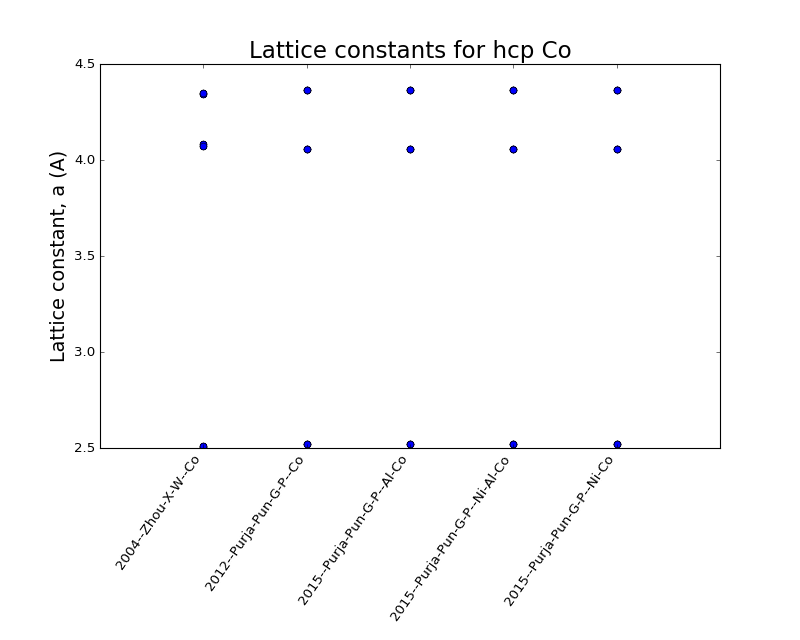

In [20]:
#Extract static values
potentials = np.asarray(static_dldf.potential_id)
lattice_a = uc.get_in_units(static_dldf.final_a, 'angstrom')
lattice_b = uc.get_in_units(static_dldf.final_b, 'angstrom')
lattice_c = uc.get_in_units(static_dldf.final_c, 'angstrom')
ticks = list(np.unique(potentials))

tickindex = np.zeros(len(potentials), dtype=int)
for i in xrange(len(potentials)):
    tickindex[i] = ticks.index(potentials[i])+1
    
#initialize pyplot plot
fig = plt.figure(figsize=(10,8),)# dpi=800)
plt.title('Lattice constants for ' + composition, size='xx-large')
plt.xticks(range(1, len(ticks)+1), ticks, rotation=55, ha = 'right')
plt.ylabel('Lattice constant, a (A)', size='x-large')
plt.xlim(0, len(ticks)+1)
#plt.ylim(4, 4.08)
plt.subplots_adjust(bottom=0.3)

#Add data
plt.plot(tickindex, lattice_a, 'ob')
plt.plot(tickindex, lattice_b, 'ob')
plt.plot(tickindex, lattice_c, 'ob')

#Extract dynamic data
potentials = np.asarray(dynamic_dldf.potential_id)
lattice_a = uc.get_in_units(dynamic_dldf.a_mean, 'angstrom')
lattice_b = uc.get_in_units(dynamic_dldf.b_mean, 'angstrom')
lattice_c = uc.get_in_units(dynamic_dldf.c_mean, 'angstrom')
err_a = uc.get_in_units(dynamic_dldf.a_std, 'angstrom')
err_b = uc.get_in_units(dynamic_dldf.b_std, 'angstrom')
err_c = uc.get_in_units(dynamic_dldf.c_std, 'angstrom')

tickindex = np.zeros(len(potentials), dtype=int)
for i in xrange(len(potentials)):
    tickindex[i] = ticks.index(potentials[i])+1

#Add data   
plt.errorbar(tickindex, lattice_a, yerr=err_a, fmt='ob')
plt.errorbar(tickindex, lattice_b, yerr=err_b, fmt='ob')
plt.errorbar(tickindex, lattice_c, yerr=err_c, fmt='ob')
    
#Show plot
plt.show()

In [21]:
err_a

array([ 0.00076139,  0.00076139,  0.00076139,  0.00075113,  0.0007941 ])

<IPython.core.display.Javascript object>


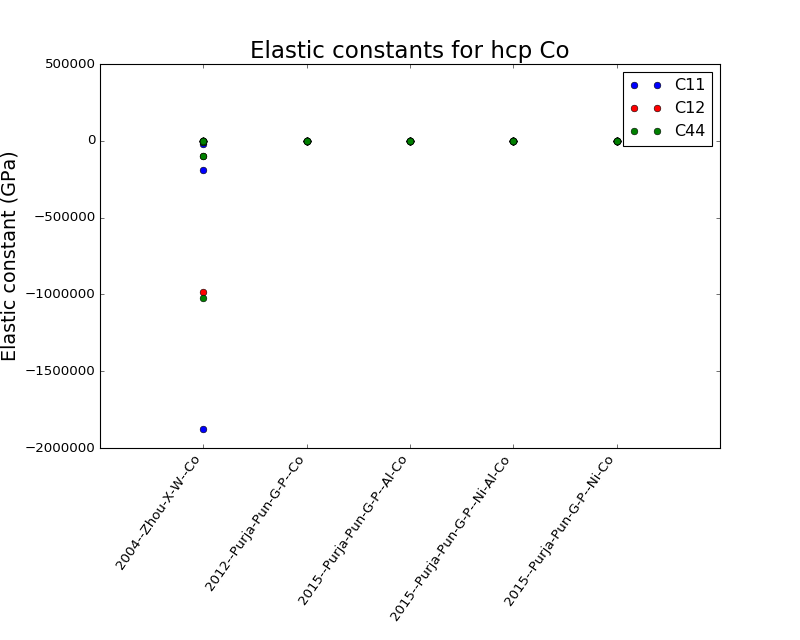

In [22]:
#Extract values
potentials = np.asarray(static_dldf.potential_id)
c11 = []
c12 = []
c44 = []
for c in static_dldf.C:
    c11.append(uc.get_in_units((c.Cij[0,0] + c.Cij[1,1] + c.Cij[2,2]) / 3, 'GPa'))
    c12.append(uc.get_in_units((c.Cij[0,1] + c.Cij[0,2] + c.Cij[1,2]) / 3, 'GPa'))
    c44.append(uc.get_in_units((c.Cij[3,3] + c.Cij[4,4] + c.Cij[5,5]) / 3, 'GPa'))

ticks = list(np.unique(potentials))
tickindex = np.zeros(len(potentials), dtype=int)
for i in xrange(len(potentials)):
    tickindex[i] = ticks.index(potentials[i])+1
    
#initialize pyplot plot
fig = plt.figure(figsize=(10,8), )#dpi=800)
plt.title('Elastic constants for ' + composition, size='xx-large')
plt.xticks(range(1, len(ticks)+1), ticks, rotation=55, ha = 'right')
plt.ylabel('Elastic constant (GPa)', size='x-large')
plt.xlim(0, len(ticks)+1)
#plt.ylim(3, 4)
plt.subplots_adjust(bottom=0.3)

#Add data
plt.plot(tickindex, c11, 'ob', label='C11')
plt.plot(tickindex, c12, 'or', label='C12')
plt.plot(tickindex, c44, 'og', label='C44')
plt.legend()
    
#Show plot
plt.show()

### Cohesive energy

In [23]:
#Extract values
potentials = np.asarray(data.potential_id)
E_coh = uc.get_in_units(data.E_cohesive, 'eV')


#Initialize bokeh plot
e_plot = figure(plot_width=800, plot_height=600, x_range=list(np.unique(potentials)))
e_plot.xaxis.major_label_orientation = 1.2
e_plot.yaxis.axis_label = 'Cohesive Energy (eV/atom)'

#Add data
e_plot.circle(potentials, E_coh, color='black')

#Add error bars
try:
    E_coh_error = uc.get_in_units(data.E_cohesive_err, 'eV')
    e_plot.segment(potentials, E_coh-E_coh_error, potentials, E_coh+E_coh_error, color='black')
except:
    pass

#Show plot
show(e_plot)

NameError: name 'data' is not defined

### Elastic constants

In [24]:
#Extract values
d = data[pd.notnull(data.C)]
potentials = np.asarray(d.potential_id)
c11 = []
c12 = []
c44 = []
for c in d.C:
    c11.append(uc.get_in_units((c.Cij[0,0] + c.Cij[1,1] + c.Cij[2,2]) / 3, 'GPa'))
    c12.append(uc.get_in_units((c.Cij[0,1] + c.Cij[0,2] + c.Cij[1,2]) / 3, 'GPa'))
    c44.append(uc.get_in_units((c.Cij[3,3] + c.Cij[4,4] + c.Cij[5,5]) / 3, 'GPa'))

#Initialize bokeh plot
c_plot = figure(plot_width=800, plot_height=600, x_range=list(np.unique(potentials)))
c_plot.xaxis.major_label_orientation = 1.2
c_plot.yaxis.axis_label = 'Elastic Constants (GPa)'

#Add data
c_plot.circle(potentials, c11, color='blue', legend='C11')
c_plot.circle(potentials, c12, color='red',  legend='C12')
c_plot.circle(potentials, c44, color='green',legend='C44')

#Show plot
show(c_plot)

NameError: name 'data' is not defined

In [ ]:
save(vplot(a_plot, e_plot, c_plot), symbols+'.html', resources=Resources(), title=symbols)

In [ ]:
if symbols == 'Al':
    pass
else:
    killit

## Look at single potential

In [25]:
#Extract values
single_df = static_df[(static_df.potential_id == '1987--Ackland-G-J--Cu') &
                      (static_df.prototype == 'A1--Cu--fcc')]


lammps_elastic_data = single_df[single_df.calc_script=='calc_LAMMPS_ELASTIC']
lammps_elastic_strain = lammps_elastic_data.strainrange
lammps_elastic_c11 = []
for c in lammps_elastic_data.C:
    lammps_elastic_c11.append(uc.get_in_units((c.Cij[0,0] + c.Cij[1,1] + c.Cij[2,2]) / 3, 'GPa'))

relax_structure_data = single_df[single_df.calc_script=='calc_refine_structure']
relax_structure_strain = relax_structure_data.strainrange
relax_structure_c11 = []
for c in relax_structure_data.C:
    relax_structure_c11.append(uc.get_in_units((c.Cij[0,0] + c.Cij[1,1] + c.Cij[2,2]) / 3, 'GPa'))

#Initialize bokeh plot
#c_plot = figure(plot_width=800, plot_height=600, x_axis_type='log', x_range=[1e-3, 1e-9], y_range=[-20,140])
#c_plot.xaxis.major_label_orientation = 1.2
#c_plot.xaxis.axis_label = 'Strain range'
#c_plot.yaxis.axis_label = 'C11 Elastic Constants (GPa)'

#Add data
#c_plot.circle(lammps_elastic_strain, lammps_elastic_c11, color='blue', alpha=0.5, size=10, legend='LAMMPS_ELASTIC')
#c_plot.circle(relax_structure_strain, relax_structure_c11, color='red', alpha=0.5, size=10,legend='relax_structure')

#Show plot
#show(c_plot)

<IPython.core.display.Javascript object>


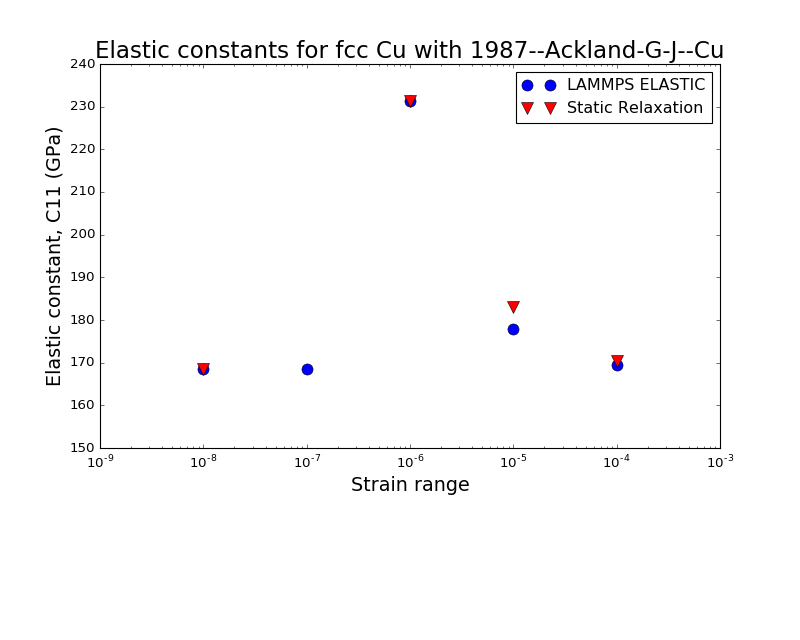

In [26]:
#initialize pyplot plot
fig = plt.figure(figsize=(10,8),)#dpi=800)
plt.title('Elastic constants for fcc Cu with 1987--Ackland-G-J--Cu', size='xx-large')
#plt.xticks(range(1, len(ticks)+1), ticks, rotation=55, ha = 'right')
plt.xlabel('Strain range', size='x-large')
plt.xscale('log')
plt.ylabel('Elastic constant, C11 (GPa)', size='x-large')
plt.xlim(1e-9,1e-3)
plt.ylim(150, 240)
plt.subplots_adjust(bottom=0.3)

#Add data
plt.plot(lammps_elastic_strain,  lammps_elastic_c11,  'ob', label='LAMMPS ELASTIC', markersize=10)
plt.plot(relax_structure_strain, relax_structure_c11, 'vr', label='Static Relaxation', markersize=10)
plt.legend(loc=1)
    
#Show plot
plt.show()

In [27]:
#Extract values
p_data = data[data.potential_id == '2004--Zhou-X-W--Al']

lammps_elastic_data = p_data[p_data.calc_id=='calc_LAMMPS_ELASTIC']
lammps_elastic_strain = lammps_elastic_data.strain_range
lammps_elastic_c12 = []
for c in lammps_elastic_data.C:
    lammps_elastic_c12.append(uc.get_in_units((c.Cij[0,1] + c.Cij[0,2] + c.Cij[1,2]) / 3, 'GPa'))

relax_structure_data = p_data[p_data.calc_id=='calc_refine_structure_static']
relax_structure_strain = relax_structure_data.strain_range
relax_structure_c12 = []
for c in relax_structure_data.C:
    relax_structure_c12.append(uc.get_in_units((c.Cij[0,1] + c.Cij[0,2] + c.Cij[1,2]) / 3, 'GPa'))

#Initialize bokeh plot
c_plot = figure(plot_width=800, plot_height=600, x_axis_type='log', x_range=[1e-3, 1e-9], y_range=[-20,140])
#c_plot.xaxis.major_label_orientation = 1.2
c_plot.xaxis.axis_label = 'Strain range'
c_plot.yaxis.axis_label = 'C12 Elastic Constants (GPa)'

#Add data
c_plot.circle(lammps_elastic_strain, lammps_elastic_c12, color='blue', alpha=0.5, size=10, legend='LAMMPS_ELASTIC')
c_plot.circle(relax_structure_strain, relax_structure_c12, color='red', alpha=0.5, size=10,legend='relax_structure')

#Show plot
show(c_plot)

NameError: name 'data' is not defined

In [28]:
#Extract values
p_data = data[data.potential_id == '2004--Zhou-X-W--Al']

lammps_elastic_data = p_data[p_data.calc_id=='calc_LAMMPS_ELASTIC']
lammps_elastic_strain = lammps_elastic_data.strain_range
lammps_elastic_c44 = []
for c in lammps_elastic_data.C:
    lammps_elastic_c44.append(uc.get_in_units((c.Cij[3,3] + c.Cij[4,4] + c.Cij[5,5]) / 3, 'GPa'))

relax_structure_data = p_data[p_data.calc_id=='calc_refine_structure_static']
relax_structure_strain = relax_structure_data.strain_range
relax_structure_c44 = []
for c in relax_structure_data.C:
    relax_structure_c44.append(uc.get_in_units((c.Cij[3,3] + c.Cij[4,4] + c.Cij[5,5]) / 3, 'GPa'))

#Initialize bokeh plot
c_plot = figure(plot_width=800, plot_height=600, x_axis_type='log', x_range=[1e-3, 1e-9], y_range=[-20,140])
#c_plot.xaxis.major_label_orientation = 1.2
c_plot.xaxis.axis_label = 'Strain range'
c_plot.yaxis.axis_label = 'C44 Elastic Constants (GPa)'

#Add data
c_plot.circle(lammps_elastic_strain, lammps_elastic_c44, color='blue', alpha=0.5, size=10, legend='LAMMPS_ELASTIC')
c_plot.circle(relax_structure_strain, relax_structure_c44, color='red', alpha=0.5, size=10,legend='relax_structure')

#Show plot
show(c_plot)

NameError: name 'data' is not defined

## Statistics check

In [29]:
lammpsmse = 0
staticmse = 0
for i, dynamic in dynamic_df[pd.isnull(dynamic_df.error)].iterrows():
    tocheck = static_df[(static_df.load == dynamic.load) & 
                        (static_df.load_options == dynamic.load_options) & 
                        (pd.isnull(static_df.error))]
    lammps = tocheck[tocheck.calc_script=='calc_LAMMPS_ELASTIC']
    static = tocheck[tocheck.calc_script=='calc_refine_structure']
    lammpsmse += np.nansum(((lammps.final_a - dynamic.a_mean) / dynamic.a_mean)**2)
    staticmse += np.nansum(((static.final_a - dynamic.a_mean) / dynamic.a_mean)**2)
lammpsmse = lammpsmse / len(lammps)
staticmse = staticmse / len(static)

In [30]:
print(lammpsmse)
print(staticmse)

241.528338559
172.090941283


In [31]:
lammpsse = np.array([])
staticse = np.array([])
for i, dynamic in dynamic_df[pd.isnull(dynamic_df.error)].iterrows():
    tocheck = static_df[(static_df.load == dynamic.load) & 
                        (static_df.load_options == dynamic.load_options) & 
                        (pd.isnull(static_df.error))]
    lammps = tocheck[tocheck.calc_script=='calc_LAMMPS_ELASTIC']
    static = tocheck[tocheck.calc_script=='calc_refine_structure']
    lammpsse = np.hstack([lammpsse, 
                          (lammps.final_a - dynamic.a_mean) / dynamic.a_mean,
                          (lammps.final_b - dynamic.b_mean) / dynamic.b_mean, 
                          (lammps.final_c - dynamic.c_mean) / dynamic.c_mean])
    
    staticse = np.hstack([staticse, 
                          (static.final_a - dynamic.a_mean) / dynamic.a_mean, 
                          (static.final_b - dynamic.b_mean) / dynamic.b_mean, 
                          (static.final_c - dynamic.c_mean) / dynamic.c_mean])

In [32]:
len(lammpsse)

104361

In [33]:
lammpsse.mean()

0.034631491931760947

In [34]:
staticse.mean()

0.028990790322878202

In [35]:
len(staticse)

96945

<IPython.core.display.Javascript object>


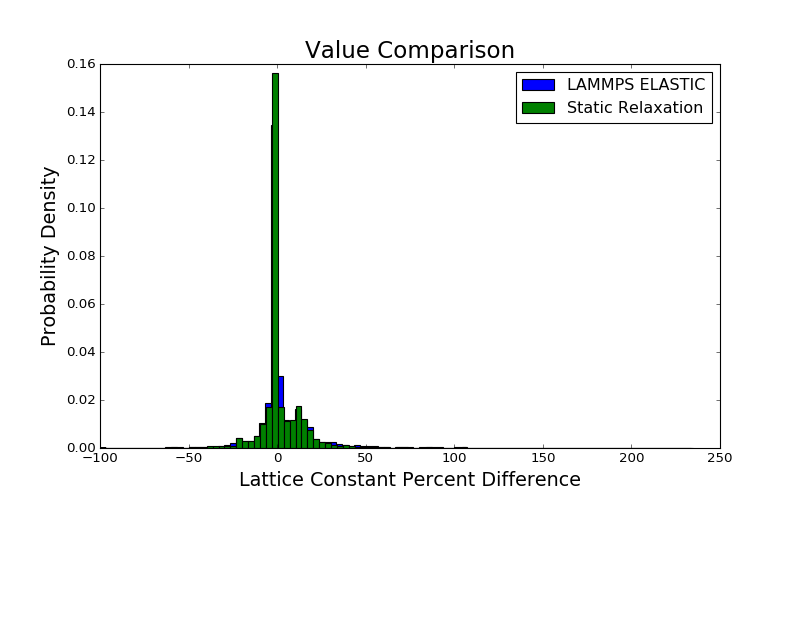

In [39]:
fig = plt.figure(figsize=(10,8), )#dpi=800)
n, bins, patches = plt.hist(lammpsse*100, 100, normed=True, label='LAMMPS ELASTIC')
n, bins, patches = plt.hist(staticse*100, 100, normed=True, label='Static Relaxation')

plt.title('Difference Relative to Dynamic Relaxation', size='xx-large')
plt.title('Value Comparison', size='xx-large')
plt.xlabel('Standardized Square Error', size='x-large')
plt.xlabel('Lattice Constant Percent Difference', size='x-large')
plt.ylabel('Probability Density', size='x-large')
#plt.yscale('log')
plt.subplots_adjust(bottom=0.3)
plt.legend(loc=1)
plt.show()

In [37]:
dynamicse = np.array([])
for i, dynamic in dynamic_df[pd.isnull(dynamic_df.error)].iterrows():
    dynamicse = np.hstack([dynamicse, 
                          ((dynamic.a_std) / dynamic.a_mean)**2,
                          ((dynamic.b_std) / dynamic.b_mean)**2, 
                          ((dynamic.c_std) / dynamic.c_mean)**2])


In [38]:
np.mean(dynamicse)

0.55221467603157925